In [1]:
#u is cone
#z is horizontal
#v is bipolar

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
%matplotlib inline

In [3]:
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=6):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

In [4]:
def K(x,s):
    return(np.exp(-(x**2/2/s**2)))/s/np.sqrt(2*np.pi)

In [5]:
xlen = 2000#spatial extend of simulation
dxc = 20/xlen
sigma_zu = int(2/dxc)#sigma_zu is horizontal cell receptive field
sigma_v = sigma_zu*0.9#sigma_v is bipolar cell receptive field
sigma_zv = sigma_zu/5#sigma_zv is horizontal to bipolar cell receptive field size
Dynamical_range = 3*sigma_zu
##Spatial kernal for horizontal cell
klen = int(sigma_zu*3)
xx = np.arange(0,klen)
khxs = K(xx,sigma_zu)
KH = np.zeros(klen*2-1)
tmp = khxs[::-1]
KH[0:klen]= tmp[0:klen]/dxc
KH[klen:2*klen]=khxs[1:klen]/dxc
##Spatial kernal for horizontal cell to bipolar cell
'''
klen = int(sigma_zv*3)
xx = np.arange(0,klen)
kzvxs = K(xx,sigma_zv)
Kzv = np.zeros(klen*2-1)
tmp = kzvxs[::-1]
Kzv[0:klen]= tmp[0:klen]/dxc
Kzv[klen:2*klen]=kzvxs[1:klen]/dxc
'''
##Spatial kernal for bipolar cell
klen = int(sigma_v*3)
xx = np.arange(0,klen)
kvxs = K(xx,sigma_v)
KV = np.zeros(klen*2-1)
tmp = kvxs[::-1]
KV[0:klen]= tmp[0:klen]/dxc
KV[klen:2*klen]=kvxs[1:klen]/dxc

In [6]:
hw = int(sigma_zu*18/22)#half of width
pos_0 = int(xlen/2)#initial position
pos = pos_0
nstep = 3000
velocity = 300#speed of bar
tau_u = 40#time constant of cone
tau_z = 2.#time constant of horizontal
tau_v = 100#time constant of bipolar
k = 40#Tune stimulus input and horizontal feedback
g = 2#Tune horizontal cell
psy = 0.5
p = 100
phi = 5
total_frequency = [0.5,1,2,4]
dms = np.arange(-99,100)
total_mi_ss = np.zeros([len(total_frequency),len(dms)])
total_mi_su = np.zeros([len(total_frequency),len(dms)])
total_mi_sv = np.zeros([len(total_frequency),len(dms)])
total_mi_svv = np.zeros([len(total_frequency),len(dms)])
total_mi_suu = np.zeros([len(total_frequency),len(dms)])



In [7]:
dt = 0.01
tau= 1
D = 27*10**5
mu, sigma = 0,1

for j in range(len(total_frequency)):
    xx = np.arange(0,xlen)
    u = np.zeros(xlen)#cone
    z = np.zeros(xlen)#horizontal cell
    v = np.zeros(xlen)#bipolar cell
    speak = np.zeros(nstep)
    upeak = np.zeros(nstep)
    vpeak = np.zeros(nstep)
    total_u = np.zeros([int(xlen),nstep])#total cones
    total_v = np.zeros([int(xlen),nstep])#total bipolar cells
    total_rzv = np.zeros([int(xlen),nstep])#total horizontal feedforward inhibition to bipolar
    total_ruv = np.zeros([int(xlen),nstep])#total horizontal feedback inhibition to cone
    zts = np.zeros([int(xlen),nstep])#horizontal
    ss = np.zeros([int(xlen),nstep])#bar
    OU=np.zeros(nstep)
    cutoffFreq = total_frequency[j]
    for i in range(nstep-1):
        OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
    LPOU = signal.filtfilt(b, a, OU)
    trajectory = (LPOU-min(LPOU))/(max(LPOU)-min(LPOU))*Dynamical_range
    trajectory = trajectory-np.mean(trajectory)
    #plt.plot(trajectory)
    
    for i in range(nstep):
        pos = pos_0+trajectory[i]
        speak[i] = pos
        s = np.zeros(xlen)#stimulus
        s[int(pos)-hw:int(pos)+hw] = 1
        ru = np.convolve(u,KH,'same')*dxc # feedback from horizontal cell
        ruv = np.convolve(u,KV,'same')*dxc # input from cone
        duj =(-tau_u*u+k*(s-phi*z))*dt#Cone
        dzj =(-tau_z*z+g*ru)*dt#horizontal
        dvj = (-tau_v*v+p*((1-psy)*ruv-psy*z))*dt#bipolar
        u = u+duj
        z = z+dzj
        v = v+dvj
        maxpos = np.argmax(u)
        upeak[i]= maxpos
        maxpos = np.argmax(v)
        vpeak[i]= maxpos
        total_u[:,i] = u
        total_v[:,i] = v
        ss[:,i] = s
        zts[:,i] = z
        #total_rzv[:,i] = rzv
        total_ruv[:,i] = ruv
    vv = total_v[pos_0,200:]
    uu = total_u[pos_0,200:]
    mi_ss = [mi_quick(speak[200:],speak[200:],d) for d in dms]
    mi_su = [mi_quick(speak[200:],upeak[200:],d) for d in dms]
    mi_sv = [mi_quick(speak[200:],vpeak[200:],d) for d in dms]
    mi_svv = [mi_quick(speak[200:],vv,d) for d in dms]
    mi_suu = [mi_quick(speak[200:],uu,d) for d in dms]
    total_mi_ss[j,:] = mi_ss
    total_mi_su[j,:] = mi_su
    total_mi_sv[j,:] = mi_sv
    total_mi_svv[j,:] = mi_svv
    total_mi_suu[j,:] = mi_suu

bipolar 0.23
bipolar 0.11
bipolar 0.04
bipolar 0.01


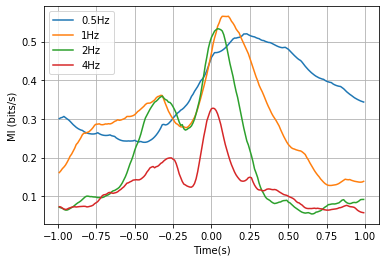

In [14]:
for i in range(len(total_frequency)):
    plt.plot(dms*dt,total_mi_svv[i,:],label=str(total_frequency[i])+'Hz')
    print('bipolar '+str(dms[np.argmax(total_mi_svv[i,:])]*dt))
plt.grid()
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('MI (bits/s)')
plt.savefig('different_frequency.jpg')

In [9]:
len(mi_ss)

199